# Example for running MDF only

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from equilibrator_api import ComponentContribution, Q_
from equilibrator_pathway import Pathway, PathwayThermoModel
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd

In [3]:
comp_contrib = ComponentContribution()
pp = Pathway.from_sbtab("ecoli_noor_2016_mdf.tsv", comp_contrib=comp_contrib)

Fragments already downloaded
Fragments already downloaded


Using license file /home/noore/opt/gurobi902/linux64/gurobi.lic
Academic license - for non-commercial use only


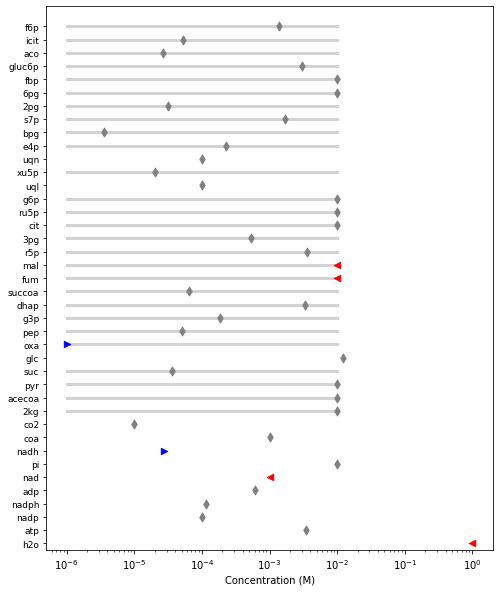

In [4]:
pp.update_standard_dgs()
mdf_result = pp.calc_mdf()

fig, ax = plt.subplots(1, 1, figsize=(8, 10))
mdf_result.plot_concentrations(ax=ax);

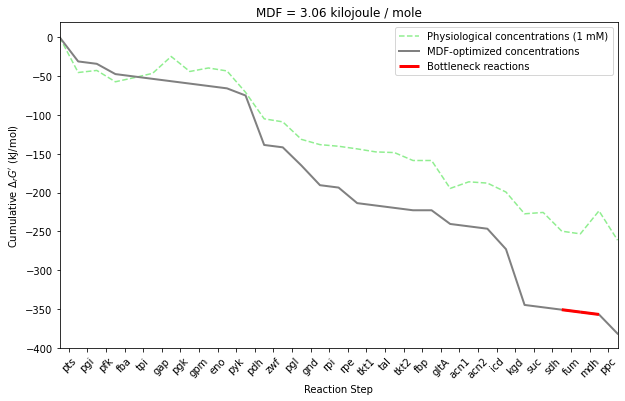

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
mdf_result.plot_driving_forces(ax=ax)

# Use Haverkorn dataset for validating ECM

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import pandas as pd
from sbtab import SBtab

from equilibrator_api import ComponentContribution, Q_
from equilibrator_pathway.cost_function import EnzymeCostFunction
from equilibrator_pathway.ecm_model import ECMmodel
from equilibrator_pathway.util import RT

In [7]:
with open("ecoli_noor_2016_ecm.tsv", "r") as fp:
    sbtabdoc_pathway = SBtab.SBtabDocument("pathway", fp.read(), "fake_filename.tsv")
with open("ecoli_noor_2016_reference.tsv", "r") as fp:
    sbtabdoc_validate = SBtab.SBtabDocument("pathway", fp.read(), "fake_filename.tsv")

In [8]:
model = ECMmodel.from_sbtab(sbtabdoc_pathway, comp_contrib=comp_contrib)
model.AddValidationData(sbtabdoc_validate)

In [9]:
print('Solving MDF problem')
_, lnC_MDF = model.MDF()
print('Solving ECM problem')
np.random.seed(1982)
_, lnC_ECM = model.ECM()
res_sbtab = model.to_sbtab(lnC_ECM)

Solving MDF problem
Solving ECM problem


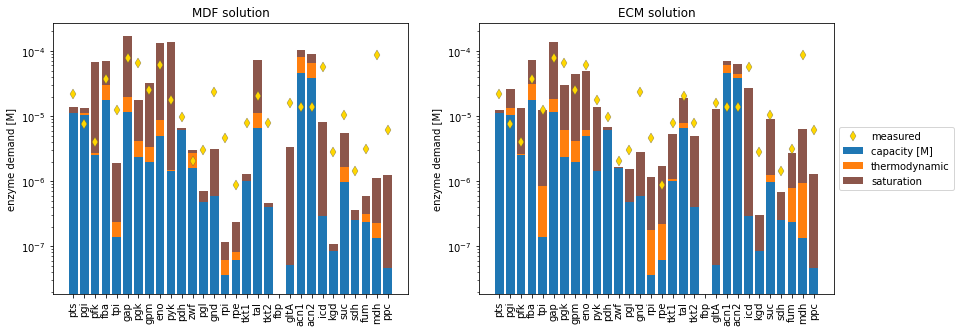

In [10]:
fig1 = plt.figure(figsize=(14, 5))
ax_MDF = fig1.add_subplot(1, 2, 1)
ax_MDF.set_title("MDF solution")
model.PlotEnzymeDemandBreakdown(lnC_MDF, ax_MDF, plot_measured=True)
ax_MDF.legend().set_visible(False)

ax_ECM = fig1.add_subplot(1, 2, 2, sharey=ax_MDF)
ax_ECM.set_title("ECM solution")
model.PlotEnzymeDemandBreakdown(lnC_ECM, ax_ECM, plot_measured=True)
ax_ECM.legend(loc="center left", bbox_to_anchor=(1, 0.5));

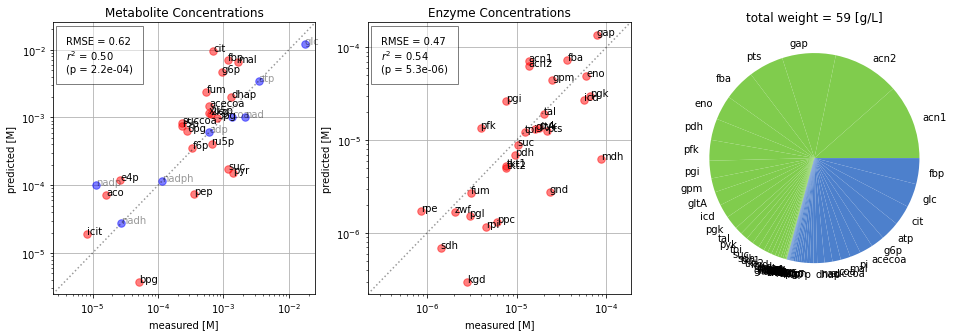

In [11]:
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(1, 3, 1, xscale='log', yscale='log')
ax.set_title('Metabolite Concentrations')
model.ValidateMetaboliteConcentrations(lnC_ECM, ax)

ax = fig.add_subplot(1, 3, 2, xscale='log', yscale='log')
ax.set_title('Enzyme Concentrations')
model.ValidateEnzymeConcentrations(lnC_ECM, ax)

ax = fig.add_subplot(1, 3, 3)
vols, labels, colors = model._GetVolumeDataForPlotting(lnC_ECM)
ax.pie(vols, labels=labels, colors=colors)
ax.set_title('total weight = %.2g [g/L]' % sum(vols));

In [12]:
output_fname = "ecm_results.tsv"
print(f"Writing the ECM results to file: {output_fname}")
res_sbtab.write(output_fname);

Writing the ECM results to file: ecm_results.tsv
